In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import networkx as nx
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

import json

In [169]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])
df = df[df['view_count'] >= 5000] # Filter out videos with view counts greater than or equal to 5000
# For each entry in the categories feature of the DataFrame df, 
# ‘entertainment’ will be set to 1 if it is 'Entertainment', otherwise it will be set to 0.
df['entertainment'] = df['categories'].apply(lambda x: 1 if 'Entertainment' in x else 0)
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

In [170]:
cons_and_enter = df[(df['entertainment'] == 1) & (df['conspiracy'] == 1)]
only_enter = df[(df['entertainment'] == 1) & (df['conspiracy'] == 0)]
only_cons = df[(df['entertainment'] == 0) & (df['conspiracy'] == 1)]
control = df[(df['entertainment'] == 0) & (df['conspiracy'] == 0)]


# 1. Descriptive Statistics

In [171]:
cons_and_enter.like_count.describe()

count      519.000000
mean      2581.579961
std       2647.678449
min         15.000000
25%        824.500000
50%       1692.000000
75%       3861.000000
max      23551.000000
Name: like_count, dtype: float64

In [172]:
only_enter.like_count.describe()

count    2.815200e+04
mean     3.984024e+03
std      1.689000e+04
min      0.000000e+00
25%      4.770000e+02
50%      1.112000e+03
75%      2.498000e+03
max      1.235449e+06
Name: like_count, dtype: float64

In [173]:
only_cons.like_count.describe()

count     2938.000000
mean      2642.297822
std       4483.900351
min          6.000000
25%        542.000000
50%       1084.000000
75%       2663.500000
max      57057.000000
Name: like_count, dtype: float64

In [174]:
control.like_count.describe()

count    1.765400e+05
mean     2.106702e+03
std      1.472457e+04
min      0.000000e+00
25%      1.650000e+02
50%      4.820000e+02
75%      1.436000e+03
max      2.864436e+06
Name: like_count, dtype: float64

We found that both the median is arranged in the following order from largest to smallest: videos that contain conspiracy theory keywords and are also in the entertainment category > videos that are purely entertainment > videos that only contain conspiracy theory keywords > control group videos.


# 2. Investigating the difference in likes between entertainment and non-entertainment videos

In [175]:
entertainment = df[df['entertainment'] == 1]
control_entertainment = df[df['entertainment'] == 0]

In [176]:
entertainment.like_count.describe()

count    2.867100e+04
mean     3.958637e+03
std      1.674125e+04
min      0.000000e+00
25%      4.840000e+02
50%      1.120000e+03
75%      2.525000e+03
max      1.235449e+06
Name: like_count, dtype: float64

In [177]:
control_entertainment.like_count.describe()

count    1.794780e+05
mean     2.115470e+03
std      1.461498e+04
min      0.000000e+00
25%      1.670000e+02
50%      4.910000e+02
75%      1.457000e+03
max      2.864436e+06
Name: like_count, dtype: float64

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


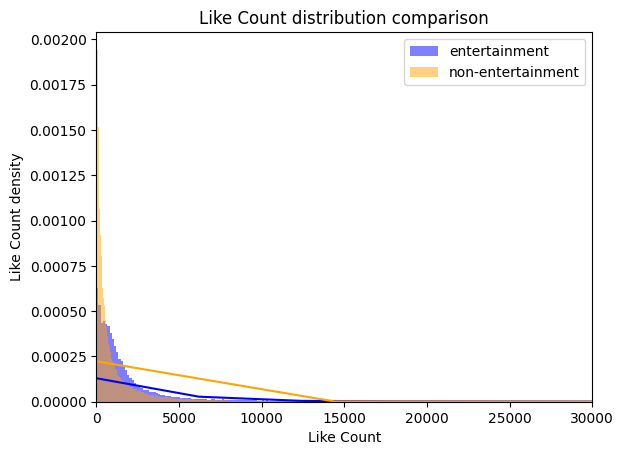

In [178]:
ax = sns.histplot(entertainment['like_count'], kde=True, stat='density', color='blue', label='entertainment')
ax = sns.histplot(control_entertainment['like_count'], kde=True, stat='density', color='orange', label='non-entertainment')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

It can be observed that in the range of 2,000 to 10,000 likes, the proportion of entertainment videos is higher.

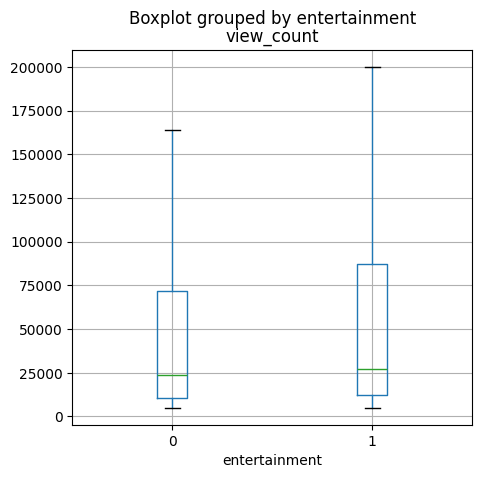

In [179]:
df.boxplot(by='entertainment', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

 Intuitively, view count may be an important factor affecting the number of likes. From this boxplot, we can see that although the means of the two groups are close, it seems that the entertainment group has a higher upper quatile for view count.


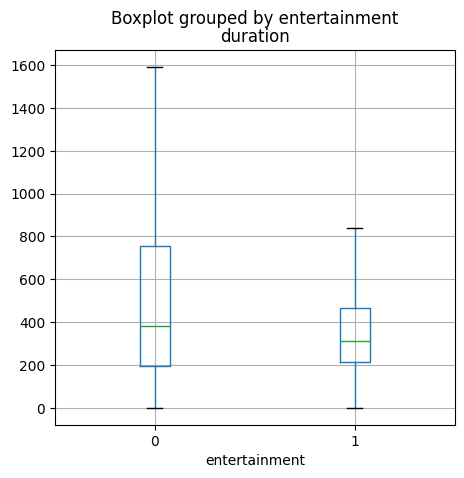

In [180]:
df.boxplot(by='entertainment', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

An interesting finding is that the videos in the non-entertainment group are often longer than those in the entertainment group.

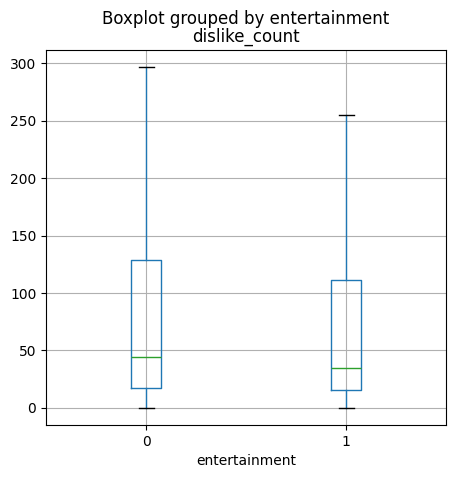

In [181]:
df.boxplot(by='entertainment', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

The non-entertainment group often has more dislikes than the entertainment group.

Many factors can influence the like count, and it is challenging to find two nearly identical videos for comparison. Therefore, we use propensity scores to balance the impact of other factors.

In [182]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

mod = smf.logit(formula='entertainment ~ dislike_count + duration + view_count + C(conspiracy)', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score_entertainment'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397908
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          entertainment   No. Observations:               208149
Model:                          Logit   Df Residuals:                   208144
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                0.007327
Time:                        20:17:03   Log-Likelihood:                -82824.
converged:                       True   LL-Null:                       -83435.
Covariance Type:            nonrobust   LLR p-value:                1.946e-263
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.8687      0.007   -277.803      0.000      -1.882      -1.856
C(con

In [183]:
entertainment = df.loc[df['entertainment'] == 1] # Videos that contain conspiracy keywords in the title or tags
control_entertainment = df.loc[df['entertainment'] == 0] # Videos that do not contain conspiracy keywords in the title or tags
# Randomly sample to reduce running time
entertainment_sample = entertainment.sample(frac=0.01, random_state=42) 
control_entertainment_sample = control_entertainment.sample(frac=0.0034, random_state=42)


In [184]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [185]:
# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in control_entertainment_sample.iterrows():
    for treatment_id, treatment_row in entertainment_sample.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score_entertainment'],
                                    treatment_row['Propensity_score_entertainment'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [186]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_entertainment = df.loc[df.index.isin(matched)]

In [187]:
entertainment = balanced_df_entertainment.loc[balanced_df_entertainment['entertainment'] == 1]
non_entertainment = balanced_df_entertainment.loc[balanced_df_entertainment['entertainment'] == 0]

In [188]:
entertainment.like_count.describe()

count       287.000000
mean       4710.637631
std       21094.810975
min           5.000000
25%         484.500000
50%        1114.000000
75%        2829.000000
max      341505.000000
Name: like_count, dtype: float64

In [189]:
non_entertainment.like_count.describe()

count       287.000000
mean       2481.459930
std        8752.690213
min           2.000000
25%         164.500000
50%         492.000000
75%        1580.000000
max      122457.000000
Name: like_count, dtype: float64

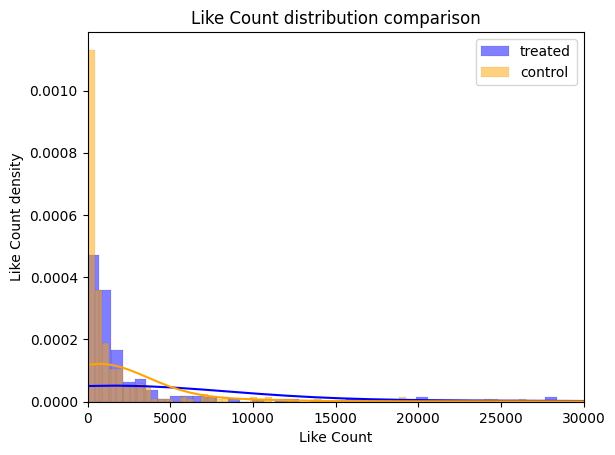

In [190]:
ax = sns.histplot(entertainment['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(non_entertainment['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

 We can observe that in the like range above 5,000, the proportion of entertainment videos is higher.

In [191]:
stats.ttest_ind(entertainment['like_count'], non_entertainment['like_count'], alternative='greater') # t-Test

TtestResult(statistic=1.6535471463835063, pvalue=0.04938411178622452, df=572.0)

Since the p-value is less than 0.05, we can reject the null hypothesis that the like count of entertainment videos is less than or equal to that of non-entertainment videos. This means that the like count of entertainment videos is significantly greater than that of non-entertainment videos.

# 3. Investigating the impact of whether a video's title or tags contain conspiracy theory keywords on the like count

In [192]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])
df = df[df['view_count'] >= 5000] # Filter out videos with view counts greater than or equal to 5000
# For each entry in the categories feature of the DataFrame df, 
# ‘entertainment’ will be set to 1 if it is 'Entertainment', otherwise it will be set to 0.
df['entertainment'] = df['categories'].apply(lambda x: 1 if 'Entertainment' in x else 0)
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

In [193]:
conspiracy = df[df['conspiracy'] == 1]
non_conspiracy = df[df['conspiracy'] == 0]

In [194]:
conspiracy.like_count.describe()

count     3457.000000
mean      2633.182239
std       4258.785839
min          6.000000
25%        574.000000
50%       1160.000000
75%       2827.000000
max      57057.000000
Name: like_count, dtype: float64

In [195]:
non_conspiracy.like_count.describe()

count    2.046920e+05
mean     2.364897e+03
std      1.505474e+04
min      0.000000e+00
25%      1.820000e+02
50%      5.520000e+02
75%      1.599000e+03
max      2.864436e+06
Name: like_count, dtype: float64

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


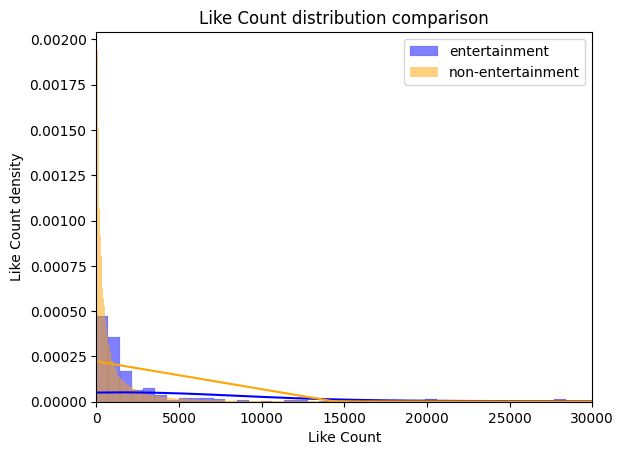

In [196]:
ax = sns.histplot(entertainment['like_count'], kde=True, stat='density', color='blue', label='entertainment')
ax = sns.histplot(control_entertainment['like_count'], kde=True, stat='density', color='orange', label='non-entertainment')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

It can be observed that in the range of > 2000 likes, the proportion of entertainment videos is higher.

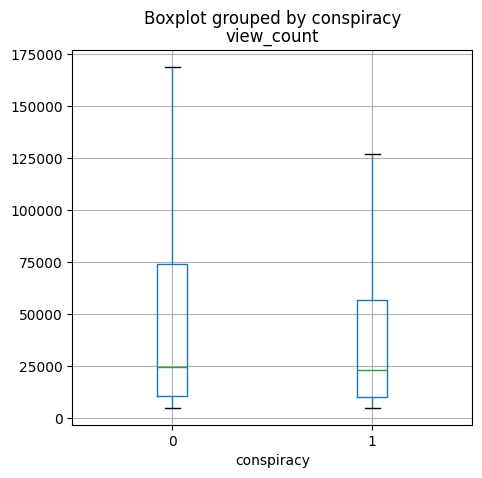

In [197]:
df.boxplot(by='conspiracy', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

View Count: We can see that although the means of the two groups are close, it seems that the non-conspiracy group has a higher upper quatile for view count.


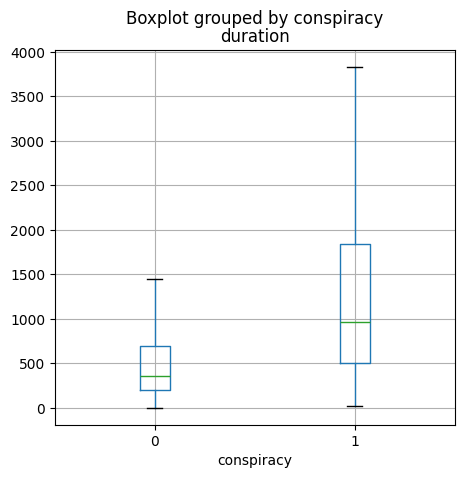

In [198]:
df.boxplot(by='conspiracy', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

An interesting finding is that the videos in the conspiracy group are often longer than those in the non-conspiracy group.

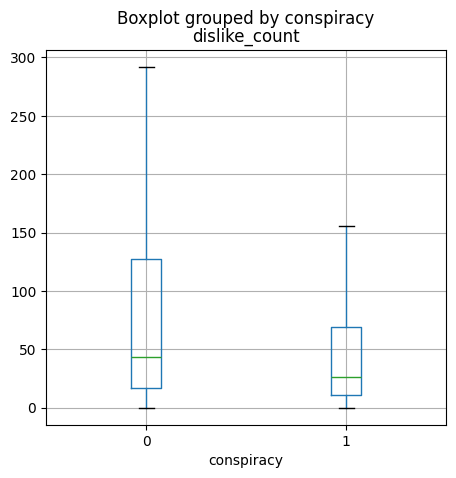

In [199]:
df.boxplot(by='conspiracy', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

The non-conspiracy group often has more dislikes than the entertainment group.

In [200]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count + C(entertainment)', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score_conspiracy'] = res.predict()

print(res.summary())

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.083908
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:               208149
Model:                          Logit   Df Residuals:                   208144
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                0.007339
Time:                        20:19:24   Log-Likelihood:                -17465.
converged:                       True   LL-Null:                       -17594.
Covariance Type:            nonrobust   LLR p-value:                 1.087e-54
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.1821      0.021   -195.253      0.000      -4.224      -4

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [201]:
conspiracy = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags
non_conspiracy = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags
# Randomly sample to reduce running time
conspiracy_sample = conspiracy.sample(frac=0.1, random_state=42) 
non_conspiracy_sample = non_conspiracy.sample(frac=0.002, random_state=42)


In [202]:
# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in non_conspiracy_sample.iterrows():
    for treatment_id, treatment_row in conspiracy_sample.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score_conspiracy'],
                                    treatment_row['Propensity_score_conspiracy'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [203]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_conspiracy = df.loc[df.index.isin(matched)]

In [204]:
conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 1]
non_conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 0]

In [205]:
conspiracy.like_count.describe()

count      346.000000
mean      2809.841040
std       4017.039265
min         86.000000
25%        603.000000
50%       1397.500000
75%       3171.750000
max      23551.000000
Name: like_count, dtype: float64

In [206]:
non_conspiracy.like_count.describe()

count       346.000000
mean       1474.343931
std        6262.360551
min           0.000000
25%         143.750000
50%         365.000000
75%        1067.250000
max      105875.000000
Name: like_count, dtype: float64

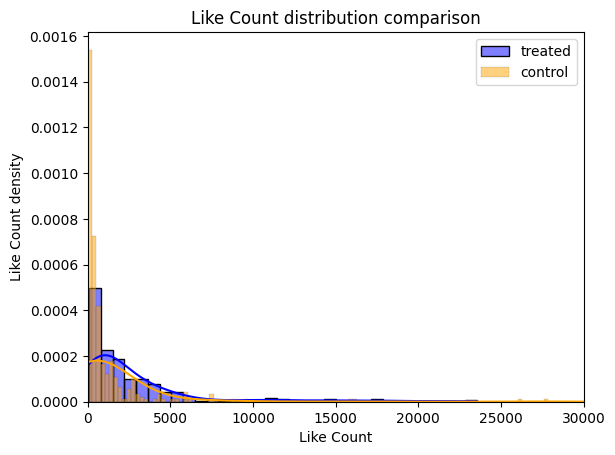

In [207]:
ax = sns.histplot(conspiracy['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(non_conspiracy['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

 We can observe that in the like range above 1,000, the proportion of entertainment videos is higher.

In [208]:
stats.ttest_ind(conspiracy['like_count'], non_conspiracy['like_count'], alternative='greater') # t-Test

TtestResult(statistic=3.3389308320991096, pvalue=0.0004431124245444349, df=690.0)

Since the p-value is less than 0.05, we can reject the null hypothesis that the like count of conspiracy videos is less than or equal to that of non-conspiracy videos. This means that the like count of conspiracy videos is significantly greater than that of non-conspiracy videos.

# 4. Plans

Next, we plan to explore the independent effects of these two factors by building a regression model. We will then add an interaction term for the two factors to examine how their interaction affects the like count. Additionally, we will further consider the video's release time as a potential factor that may influence the like count.